# Figure 1c: Nonsynonymous and synonymous SNPs/site

June 6, 2019 

This notebook contains code for producing the diversity analyses as shown in **Supplementary Table 1** and for plotting **Figure 1c**. 

In both **Supplementary Table 1** and **Figure 1c**, the the mean nonsynonymous diversity (πN) and synonymous diversity (πS), per gene, per species is displayed. These were calculated for each gene in each individual sample by taking the number of synonymous or nonsynonymous SNPs called in that gene and sample, divided by the total number of synonymous or nonsynonymous sites present in that gene and sample. SNPs were called with Varscan using the [pipeline here](https://github.com/lmoncla/illumina_pipeline), requiring a minimum coverage of 100x, a minimum frequency of 1%, and a minimum qscore of Q30, and presence on forward and reverse reads. This is also described in the Methods of the manuscript. To define the number of synonymous and nonsynonymous sites per gene, I used [SNPGenie](https://github.com/chasewnelson/SNPGenie), which uses the [Nei-Gojobori (1986) method](https://academic.oup.com/mbe/article/3/5/418/988012). 


In [1]:
import sys, subprocess, glob, os, shutil, re, importlib, Bio
from subprocess import call
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rpy2
import seaborn as sns
from scipy import stats

%load_ext rpy2.ipython 

In [40]:
# define colors 
human_color = "#C75643"
duck_color = "#545AB7"

duck_nonsyn_color = "#545AB7"
duck_syn_color = "#98B4DA"
human_nonsyn_color = "#C75643"
human_syn_color = "#E6B692"

pd.set_option('display.max_rows', 500)

In [41]:
# variant calls file to load in
variant_calls = "/Users/lmoncla/src/h5n1-cambodia/data/within-host-variants-1%.txt"

In [43]:
snps_df = pd.read_csv(variant_calls, sep='\t', header='infer')
snps_df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN


In [44]:
# reformat the sampleid 
snps_df['sampleid'] = snps_df['sampleid'].str[14:]
snps_df['sample'] = snps_df['sample'].str.replace("/","_")
snps_df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
0,A_duck_Cambodia_381W11M4_2013_H5,A_duck_Cambodia_381W11M4_2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
1,A_duck_Cambodia_381W11M4_2013_NP,A_duck_Cambodia_381W11M4_2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
2,A_duck_Cambodia_381W11M4_2013_PA,A_duck_Cambodia_381W11M4_2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN
3,A_duck_Cambodia_381W11M4_2013_PA,A_duck_Cambodia_381W11M4_2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
4,A_duck_Cambodia_381W11M4_2013_PA,A_duck_Cambodia_381W11M4_2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN


In [45]:
# get rid of the incorrect variant call due to a mismatched reference base
snps_df = snps_df[snps_df['coding_region_change'] != 'Xaa240Gly']
snps_df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
0,A_duck_Cambodia_381W11M4_2013_H5,A_duck_Cambodia_381W11M4_2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
1,A_duck_Cambodia_381W11M4_2013_NP,A_duck_Cambodia_381W11M4_2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
2,A_duck_Cambodia_381W11M4_2013_PA,A_duck_Cambodia_381W11M4_2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN
3,A_duck_Cambodia_381W11M4_2013_PA,A_duck_Cambodia_381W11M4_2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
4,A_duck_Cambodia_381W11M4_2013_PA,A_duck_Cambodia_381W11M4_2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN


In [46]:
# change NAs to neuramindase
snps_df['gene'].fillna('neuraminidase', inplace=True)

In [47]:
# count the number of SNPs per gene per sample and output as a dataframe
counts = pd.DataFrame(snps_df.groupby(["sample", "gene","synonymous_nonsynonymous"]).size())
counts.reset_index(inplace=True)
counts.columns = ['sample','gene','synonymous_nonsynonymous','number_of_SNPs']
counts = counts[counts['synonymous_nonsynonymous'] != 'stop_gained']   # remove stop gained
counts.head()

,sample,gene,synonymous_nonsynonymous,number_of_SNPs
0,A_CAMBODIA_V0401301_2011,HA,nonsynonymous,12
1,A_CAMBODIA_V0401301_2011,HA,synonymous,1
2,A_CAMBODIA_V0401301_2011,M1,nonsynonymous,1
4,A_CAMBODIA_V0401301_2011,NP,nonsynonymous,4
5,A_CAMBODIA_V0401301_2011,NP,synonymous,2


In [48]:
# unmelt the synonymous nonsynonymous column
counts = counts.pivot_table(index = ['sample','gene'], columns = 'synonymous_nonsynonymous', values='number_of_SNPs')
counts.reset_index(inplace=True)
counts = counts.fillna(0)
counts.head()

synonymous_nonsynonymous,sample,gene,nonsynonymous,synonymous
0,A_CAMBODIA_V0401301_2011,HA,12.0,1.0
1,A_CAMBODIA_V0401301_2011,M1,1.0,0.0
2,A_CAMBODIA_V0401301_2011,NP,4.0,2.0
3,A_CAMBODIA_V0401301_2011,PA,8.0,1.0
4,A_CAMBODIA_V0401301_2011,PB1,4.0,4.0


In [49]:
# add in a species column
counts['species'] = counts['sample'].str.contains("duck")
counts['species'] = counts['species'].replace(True,"duck")
counts['species'] = counts['species'].replace(False,"human")
counts.head()

synonymous_nonsynonymous,sample,gene,nonsynonymous,synonymous,species
0,A_CAMBODIA_V0401301_2011,HA,12.0,1.0,human
1,A_CAMBODIA_V0401301_2011,M1,1.0,0.0,human
2,A_CAMBODIA_V0401301_2011,NP,4.0,2.0,human
3,A_CAMBODIA_V0401301_2011,PA,8.0,1.0,human
4,A_CAMBODIA_V0401301_2011,PB1,4.0,4.0,human


In [50]:
len(counts)

74

In [51]:
counts

synonymous_nonsynonymous,sample,gene,nonsynonymous,synonymous,species
0,A_CAMBODIA_V0401301_2011,HA,12.0,1.0,human
1,A_CAMBODIA_V0401301_2011,M1,1.0,0.0,human
2,A_CAMBODIA_V0401301_2011,NP,4.0,2.0,human
3,A_CAMBODIA_V0401301_2011,PA,8.0,1.0,human
4,A_CAMBODIA_V0401301_2011,PB1,4.0,4.0,human
5,A_CAMBODIA_V0401301_2011,PB2,2.0,4.0,human
6,A_CAMBODIA_V0401301_2011,neuraminidase,5.0,5.0,human
7,A_CAMBODIA_V0417301_2011,HA,4.0,2.0,human
8,A_CAMBODIA_V0417301_2011,M2,1.0,0.0,human
9,A_CAMBODIA_V0417301_2011,NP,0.0,2.0,human


In [52]:
# write out counts to a dictionary 
counts_dict = counts.to_dict('index')
counts_dict

{0: {'gene': 'HA',
  'nonsynonymous': 12.0,
  'sample': 'A_CAMBODIA_V0401301_2011',
  'species': 'human',
  'synonymous': 1.0},
 1: {'gene': 'M1',
  'nonsynonymous': 1.0,
  'sample': 'A_CAMBODIA_V0401301_2011',
  'species': 'human',
  'synonymous': 0.0},
 2: {'gene': 'NP',
  'nonsynonymous': 4.0,
  'sample': 'A_CAMBODIA_V0401301_2011',
  'species': 'human',
  'synonymous': 2.0},
 3: {'gene': 'PA',
  'nonsynonymous': 8.0,
  'sample': 'A_CAMBODIA_V0401301_2011',
  'species': 'human',
  'synonymous': 1.0},
 4: {'gene': 'PB1',
  'nonsynonymous': 4.0,
  'sample': 'A_CAMBODIA_V0401301_2011',
  'species': 'human',
  'synonymous': 4.0},
 5: {'gene': 'PB2',
  'nonsynonymous': 2.0,
  'sample': 'A_CAMBODIA_V0401301_2011',
  'species': 'human',
  'synonymous': 4.0},
 6: {'gene': 'neuraminidase',
  'nonsynonymous': 5.0,
  'sample': 'A_CAMBODIA_V0401301_2011',
  'species': 'human',
  'synonymous': 5.0},
 7: {'gene': 'HA',
  'nonsynonymous': 4.0,
  'sample': 'A_CAMBODIA_V0417301_2011',
  'species': '

## Read in # of synonymous and nonsynonymous sites per gene per sample 

These results are from running SNPGenie and calculating pi. I will not be using the pi estimates, but will be using the number of synonymous and nonsynonymous sites per gene estimates. 

In [53]:
# read in SNPgenie pi data for each sample and gene to get the number of synonymous and nonsynonymous sites 
snp_genie_results = "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/SNPGenie_diversity_estimates/1_percent_SNPs-2018-05-10/"

In [54]:
sites_dict = {}

for f in glob.glob(snp_genie_results + "*/SNPGenie_Results/product_results.txt"):
    with open(f,"r") as infile: 
        sampleid = f.replace(snp_genie_results, "").split("/")[0][14:]
        gene = sampleid.split("_")[-1]
        sample = sampleid.replace("_"+gene, "")
        
        # change sample id to match the SNPs df 
        sampleid = sampleid.replace("M1","MP")
        sampleid = sampleid.replace("M2","MP")
        sampleid = sampleid.replace("NS1","NS")
        sampleid = sampleid.replace("NEP","NS")
        
        gene = gene.replace("H5","HA")
        gene = gene.replace("N1","neuraminidase")
                
        if sample not in sites_dict:
            sites_dict[sample] = {gene:{}}
                
        for line in infile: 
            if "file" not in line: 
                Nsites = line.split()[6]
                Ssites = line.split()[7]
                
        sites_dict[sample][gene] = {"Nsites": Nsites, "Ssites":Ssites}

In [55]:
# go through dictionary and add in missing rows for missing genes that do not have SNPs; still need to count these as 0 
# the exception is PB1 for A/Cambodia/X0128304/2013 which just doesn't have data 

genes = ['PB2','PB1','PA','HA','NP','neuraminidase','M1','M2','NS1','NEP']
has_snps = {}
no_snps = {}

for i in counts_dict:
    sample = counts_dict[i]['sample']
    gene = counts_dict[i]['gene']
    
    if sample not in has_snps: 
        has_snps[sample] = []
    
    has_snps[sample].append(gene)

# now loop through to output ones without snps 
for s in has_snps: 
    for g in genes: 
        if g not in has_snps[s]:
            if g == 'PB1' and s == 'A_Cambodia_X0128304_2013':
                pass
            else:
                if s not in no_snps:
                    no_snps[s] = []
                    no_snps[s].append(g)
                elif s in no_snps:
                    no_snps[s].append(g)
            
print(no_snps)

{'A_CAMBODIA_V0401301_2011': ['M2', 'NS1', 'NEP'], 'A_CAMBODIA_V0417301_2011': ['PB1', 'M1', 'NS1', 'NEP'], 'A_Cambodia_W0112303_2012': ['neuraminidase', 'M1', 'M2', 'NS1', 'NEP'], 'A_Cambodia_X0125302_2013': ['NP', 'NEP'], 'A_Cambodia_X0207301_2013': ['PB2', 'M2'], 'A_Cambodia_X0219301_2013': ['PB1', 'HA', 'neuraminidase', 'M1', 'M2', 'NS1', 'NEP'], 'A_Cambodia_X1030304_2013': ['NP', 'neuraminidase', 'NEP'], 'A_duck_Cambodia_083D1_2011': ['PB2', 'PA', 'M2', 'NS1', 'NEP'], 'A_duck_Cambodia_381W11M4_2013': ['neuraminidase', 'M1', 'M2', 'NS1', 'NEP'], 'A_duck_Cambodia_PV027D1_2010': ['PB2', 'HA', 'NP', 'neuraminidase', 'M2', 'NS1', 'NEP'], 'A_duck_Cambodia_Y0224301_2014': ['PB2', 'PB1', 'NP', 'M1', 'M2'], 'A_duck_Cambodia_Y0224304_2014': ['PB1', 'PA', 'neuraminidase', 'M1', 'M2', 'NS1', 'NEP']}


In [57]:
# write nosnps out to a dataframe 
no_snps_df = pd.DataFrame()

for s in no_snps: 
    for g in no_snps[s]:
        sampleid = s + "_" + g
        if "duck" in s:
            species = "duck"
        else:
            species = "human"
                
        d = pd.DataFrame(np.array([[s,g, 0,0,species,0,0,0,0]]))
        d.columns = ['sample','gene','nonsynonymous','synonymous','species','Nsites','Ssites','N_per_site','S_per_site']

        no_snps_df = no_snps_df.append(d)

no_snps_df.head()

,sample,gene,nonsynonymous,synonymous,species,Nsites,Ssites,N_per_site,S_per_site
0,A_CAMBODIA_V0401301_2011,M2,0,0,human,0,0,0,0
0,A_CAMBODIA_V0401301_2011,NS1,0,0,human,0,0,0,0
0,A_CAMBODIA_V0401301_2011,NEP,0,0,human,0,0,0,0
0,A_CAMBODIA_V0417301_2011,PB1,0,0,human,0,0,0,0
0,A_CAMBODIA_V0417301_2011,M1,0,0,human,0,0,0,0


In [58]:
# convert the nonsynonymous and synonymous sites per gene to a dataframe
sites_df = pd.DataFrame()

for s in sites_dict: 
    
    for g in sites_dict[s]:
        df = pd.DataFrame.from_dict(sites_dict[s][g], orient="index").T
        df['sample'] = s
        df['gene'] = g
    
        sites_df = sites_df.append(df)

sites_df.head()

,Nsites,Ssites,sample,gene
0,1332.74039747032,370.650906877508,A_Cambodia_X0128304_2013,HA
0,578.515593779322,177.484406220678,A_Cambodia_X0128304_2013,M1
0,227,64,A_Cambodia_X0128304_2013,M2
0,1050.11942257218,296.880577427822,A_Cambodia_X0128304_2013,neuraminidase
0,286.009963768116,76.990036231884,A_Cambodia_X0128304_2013,NEP


In [59]:
len(sites_df)

87

## Merge together the SNP counts dataframe and the synonymous/nonsynonymous lengths dataframe

In [60]:
# merge the dataframes including the counts of SNPs and the synonymous and nonsynonymou sites
merged = counts.merge(sites_df, on=['sample','gene'], how='outer')
merged = merged.dropna()
merged.head()

,sample,gene,nonsynonymous,synonymous,species,Nsites,Ssites
0,A_CAMBODIA_V0401301_2011,HA,12.0,1.0,human,1332.9534942423,371.046505757698
1,A_CAMBODIA_V0401301_2011,M1,1.0,0.0,human,1332.9534942423,371.046505757698
2,A_CAMBODIA_V0401301_2011,NP,4.0,2.0,human,1148.01647108678,345.983528913223
3,A_CAMBODIA_V0401301_2011,PA,8.0,1.0,human,1684.40017392789,463.421018125091
4,A_CAMBODIA_V0401301_2011,PB1,4.0,4.0,human,1767.9268235821,503.073176417901


In [61]:
# add a column for nonsynonymous and synonymous per site 
merged['N_per_site'] = merged['nonsynonymous'].astype(float) / merged['Nsites'].astype(float)
merged['S_per_site'] = merged['synonymous'].astype(float) / merged['Ssites'].astype(float)
merged.head()

,sample,gene,nonsynonymous,synonymous,species,Nsites,Ssites,N_per_site,S_per_site
0,A_CAMBODIA_V0401301_2011,HA,12.0,1.0,human,1332.9534942423,371.046505757698,0.009003,0.002695
1,A_CAMBODIA_V0401301_2011,M1,1.0,0.0,human,1332.9534942423,371.046505757698,0.000750,0.000000
2,A_CAMBODIA_V0401301_2011,NP,4.0,2.0,human,1148.01647108678,345.983528913223,0.003484,0.005781
3,A_CAMBODIA_V0401301_2011,PA,8.0,1.0,human,1684.40017392789,463.421018125091,0.004749,0.002158
4,A_CAMBODIA_V0401301_2011,PB1,4.0,4.0,human,1767.9268235821,503.073176417901,0.002263,0.007951


In [62]:
# add in the no snps dataframe
merged = merged.append(no_snps_df)
#merged.dropna(inplace=True)
merged.reset_index(inplace=True)

In [63]:
# get rid of MP and NS columns and fill NA values with 0
merged = merged[merged['gene'] != 'MP']
merged = merged[merged['gene'] != 'NS']
merged = merged.fillna(0.0)
merged

,index,sample,gene,nonsynonymous,synonymous,species,Nsites,Ssites,N_per_site,S_per_site
0,0,A_CAMBODIA_V0401301_2011,HA,12,1,human,1332.9534942423,371.046505757698,0.00900256,0.00269508
1,1,A_CAMBODIA_V0401301_2011,M1,1,0,human,1332.9534942423,371.046505757698,0.000750214,0
2,2,A_CAMBODIA_V0401301_2011,NP,4,2,human,1148.01647108678,345.983528913223,0.00348427,0.00578062
3,3,A_CAMBODIA_V0401301_2011,PA,8,1,human,1684.40017392789,463.421018125091,0.00474947,0.00215787
4,4,A_CAMBODIA_V0401301_2011,PB1,4,4,human,1767.9268235821,503.073176417901,0.00226254,0.00795113
5,5,A_CAMBODIA_V0401301_2011,PB2,2,4,human,1759.40919088767,517.528122545167,0.00113675,0.00772905
6,6,A_CAMBODIA_V0401301_2011,neuraminidase,5,5,human,1049.14877034739,297.851229652607,0.00476577,0.0167869
7,7,A_CAMBODIA_V0417301_2011,HA,4,2,human,1332.78501496308,371.21498503692,0.00300123,0.00538771
8,8,A_CAMBODIA_V0417301_2011,M2,1,0,human,227.806260575296,63.1937394247039,0.00438969,0
9,9,A_CAMBODIA_V0417301_2011,NP,0,2,human,1147.62311557789,346.37688442211,0,0.00577406


In [64]:
# create a new dataframe with the mean and standard deviation per gene 
d = merged.melt(id_vars = ['gene','species'] ,value_vars = ['N_per_site','S_per_site'])
d['value'] = pd.to_numeric(d['value'])
mean = d.groupby(["gene", 'species','variable']).mean()
mean.reset_index(inplace=True)
mean.columns = ['gene','species','variable','mean']

std = d.groupby(["gene", 'species','variable']).std()
std.reset_index(inplace=True)
std.columns = ['gene','species','variable','std']

df1 = mean.merge(std, on=['gene','species','variable'], how="outer")
df1 = df1[df1['species'] != 0]
df1.fillna(0)
df1.head()

,gene,species,variable,mean,std
0,HA,duck,N_per_site,0.000451,0.000412
1,HA,duck,S_per_site,0.001078,0.001476
2,HA,human,N_per_site,0.002626,0.003258
3,HA,human,S_per_site,0.003370,0.002792
4,M1,duck,N_per_site,0.000693,0.000949


In [65]:
# add in a color column 
df1['color'] = df1['species'] + " " + df1['variable']
df1['color'] = df1['color'].str.replace("_per_site","")
df1['color'] = df1['color'].str.replace("N","nonsynonymous")
df1['color'] = df1['color'].str.replace("S","synonymous")
df1.head()

,gene,species,variable,mean,std,color
0,HA,duck,N_per_site,0.000451,0.000412,duck nonsynonymous
1,HA,duck,S_per_site,0.001078,0.001476,duck synonymous
2,HA,human,N_per_site,0.002626,0.003258,human nonsynonymous
3,HA,human,S_per_site,0.003370,0.002792,human synonymous
4,M1,duck,N_per_site,0.000693,0.000949,duck nonsynonymous


In [66]:
df1.head()

,gene,species,variable,mean,std,color
0,HA,duck,N_per_site,0.000451,0.000412,duck nonsynonymous
1,HA,duck,S_per_site,0.001078,0.001476,duck synonymous
2,HA,human,N_per_site,0.002626,0.003258,human nonsynonymous
3,HA,human,S_per_site,0.003370,0.002792,human synonymous
4,M1,duck,N_per_site,0.000693,0.000949,duck nonsynonymous


### Output N/S ratio 

In [68]:
%%R -w 1000 -h 500 -u px -i  df1  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
require(reshape2)
library(reshape2)

x = dcast(df1, gene + species ~ variable, value.var="mean")
x$NoverS = x$N_per_site/x$S_per_site

x

            gene species   N_per_site  S_per_site     NoverS
1             HA    duck 0.0004509564 0.001077965 0.41834065
2             HA   human 0.0026260653 0.003369991 0.77924987
3             M1    duck 0.0006930732 0.000000000        Inf
4             M1   human 0.0016061623 0.004932866 0.32560429
5             M2    duck 0.0000000000 0.000000000        NaN
6             M2   human 0.0027513567 0.000000000        Inf
7            NEP    duck 0.0006993369 0.002596903 0.26929652
8            NEP   human 0.0008741568 0.000000000        Inf
9  neuraminidase    duck 0.0001905669 0.001344915 0.14169445
10 neuraminidase   human 0.0010722238 0.005042748 0.21262689
11            NP    duck 0.0008723596 0.003449184 0.25291768
12            NP   human 0.0010897117 0.004317580 0.25238948
13           NS1    duck 0.0007684918 0.000000000        Inf
14           NS1   human 0.0002401537 0.004857915 0.04943555
15            PA    duck 0.0001189252 0.001717627 0.06923805
16            PA   human

## Compare nonsynonymous to synonymous diversity for full genome

In [69]:
# separate out human and duck 
df = merged.copy()

human = df[df['species'] =="human"]
duck = df[df['species'] =="duck"]

meanNSh = human['N_per_site'].astype(float).mean()
meanSh = human['S_per_site'].astype(float).mean()
stdNSh = human['N_per_site'].astype(float).std()
stdSh = human['S_per_site'].astype(float).std()
NoverSh = meanNSh/meanSh

meanNSh, stdNSh, meanSh, stdSh, NoverSh

(0.0013911435148309854,
 0.002100978307636747,
 0.003415974507324383,
 0.00459111382375162,
 0.40724645685972083)

In [71]:
meanNSd = duck['N_per_site'].astype(float).mean()
meanSd = duck['S_per_site'].astype(float).mean()
stdNSd = duck['N_per_site'].astype(float).std()
stdSd = duck['S_per_site'].astype(float).std()
NoverSd = meanNSd/meanSd

meanNSd, stdNSd, meanSd, stdSd, NoverSd

(0.00039069523619551517,
 0.0008691571147512671,
 0.0013279114279839185,
 0.00299946696552858,
 0.2942178431197646)

In [72]:
# add in full genome values to plot 
fg = {'gene':['full\ngenome','full\ngenome','full\ngenome','full\ngenome'],
      'species':['human','human','duck','duck'],
      'variable':['N_per_site','S_per_site','N_per_site','S_per_site'],
      'mean':[meanNSh,meanSh,meanNSd,meanSd],'std':[stdNSh,stdSh,stdNSd,stdSd],
      'color':["human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"]}
fg_df = pd.DataFrame(fg)
fg_df

,gene,species,variable,mean,std,color
0,full\ngenome,human,N_per_site,0.001391,0.002101,human nonsynonymous
1,full\ngenome,human,S_per_site,0.003416,0.004591,human synonymous
2,full\ngenome,duck,N_per_site,0.000391,0.000869,duck nonsynonymous
3,full\ngenome,duck,S_per_site,0.001328,0.002999,duck synonymous


In [73]:
df2 = df1.append(fg_df)
df2.tail()

,gene,species,variable,mean,std,color
39,neuraminidase,human,S_per_site,0.005043,0.005676,human synonymous
0,full\ngenome,human,N_per_site,0.001391,0.002101,human nonsynonymous
1,full\ngenome,human,S_per_site,0.003416,0.004591,human synonymous
2,full\ngenome,duck,N_per_site,0.000391,0.000869,duck nonsynonymous
3,full\ngenome,duck,S_per_site,0.001328,0.002999,duck synonymous


In [74]:
%%R -w 1000 -h 500 -u px -i  df2,human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)

# this block of code is to ensure that even genes without SNPs get plotted so that the bars are all the same size
species_list = unique(df2$species)
gene_list = unique(df2$gene)
variables_list = unique(df2$variable)

for (species in species_list)
{
    for (gene in gene_list)
    {
        for (variable in variables_list)
        {
            x = df2[df2$species == species & df2$gene == gene & df2$variable == variable,]
            if (nrow(x) == 0){
                mean = 0
                std = 0
                if (variable == "N_per_site"){
                    color = paste(species, "nonsynonymous")
                } else{
                    color = paste(species, "synonymous")
                }
                row_to_append = data.frame(gene, species, variable, mean, std, color)
                df1 = rbind(df1, row_to_append)
            }
        }
    }
}

df2$gene = gsub("neuraminidase","NA", df2$gene)
df2$colorf = factor(df2$color, levels=c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"))
df2$genef = factor(df2$gene, levels=c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP','full\ngenome'))

p <- ggplot(data=df2, aes(x=genef, y=mean, color=colorf, fill=colorf)) + 
    geom_col(position="dodge")+   
    geom_errorbar(data=df2, aes(x=genef, ymin=mean - std, ymax=mean+std), position="dodge")+
    labs(x="Gene",y="SNVs/site")+
    scale_color_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    scale_fill_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    #ggtitle("random tables simulation") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #facet_wrap(~genef, scales="free")+
    scale_y_continuous(limits=c(-0.005,0.015))+
    theme(strip.text = element_text(size=16))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.65, "cm"))+
    #theme(legend.key=element_rect(fill=NA,size = 2))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-1c-NS_S_SNPs_per_site-2019-06-04.pdf", p, width = 14, height = 6, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-06-04/individual-PDFs")
p

/Users/lmoncla/anaconda/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


### Compare human to duck

In [75]:
# compare human to duck NS rates with a t-test
h_NS = human['N_per_site'].astype(float)
d_NS = duck['N_per_site'].astype(float)

stats.ttest_ind(h_NS, d_NS, axis=0, equal_var=False)

Ttest_indResult(statistic=3.7550521007245345, pvalue=0.0002758219395960405)

In [76]:
# compare human to duck S rates with a t-test
h_S = human['S_per_site'].astype(float)
d_S = duck['S_per_site'].astype(float)

stats.ttest_ind(h_S, d_S, axis=0, equal_var=False)

Ttest_indResult(statistic=3.1240011827810825, pvalue=0.0022111998964308853)

### Compare nonsynonymous to synonymous within a species

In [77]:
# compare NS to S for humans, full genome
stats.ttest_ind(h_NS, h_S, axis=0, equal_var=False)

Ttest_indResult(statistic=-3.5644838922096644, pvalue=0.0005419892842828632)

In [78]:
# compare NS to S for ducks, full genome
stats.ttest_ind(d_NS, d_S, axis=0, equal_var=False)

Ttest_indResult(statistic=-2.122133397749984, pvalue=0.038171341885881165)

### Full genome results: 

**1. Test whether the rates of synonymous and nonsynonymous diversity are different across the full genome in each species separately:**

Humans: p = 0.00054 (yes, more synonymous than nonsynonymous diversity)

Ducks: p = 0.038 (yes, more synonymous than nonsynonymous diversity) 


**2. Test whether there is a difference between human and duck rates of nonsynonymous and synonymous diversity across the genomes**

Human vs. duck nonsynonymous: p = 0.00012 (yes, humans have more nonsynonymous diversity than ducks) 

Human vs. duck synonymous: p = 0.00017 (yes, humans have more synonymous diversity than ducks)

Overall, the mean, genome-wide ratio of piN/piS is human: 0.35, 0.29

## Compare diversity results per gene

In [82]:
# results per gene 

## This is the code that Dane helped me with 
merged['N_per_site'] = merged.N_per_site.astype(float)
merged['S_per_site'] = merged.S_per_site.astype(float)

human = merged[merged['species'] == 'human'][['sample','species','gene','N_per_site','S_per_site']]
duck = merged[merged['species'] == 'duck'][['sample','species','gene','N_per_site','S_per_site']]

human.head()

,sample,species,gene,N_per_site,S_per_site
0,A_CAMBODIA_V0401301_2011,human,HA,0.009003,0.002695
1,A_CAMBODIA_V0401301_2011,human,M1,0.000750,0.000000
2,A_CAMBODIA_V0401301_2011,human,NP,0.003484,0.005781
3,A_CAMBODIA_V0401301_2011,human,PA,0.004749,0.002158
4,A_CAMBODIA_V0401301_2011,human,PB1,0.002263,0.007951


In [83]:
humanList = []
geneList2 = []

geneList = list(set(human['gene']))
for g in geneList:
    geneList2.append(g +"_"+ "NS")
    geneList2.append(g +"_"+ "S")

for gene in geneList:
    genedf_NS = human[human['gene'] == gene]['N_per_site']
    genedf_NS = genedf_NS.reset_index(drop=True)
    
    genedf_S = human[human['gene'] == gene]['S_per_site']
    genedf_S = genedf_S.reset_index(drop=True)

    humanList.append(genedf_NS)
    humanList.append(genedf_S)
    
    human_compare = pd.concat(humanList, axis=1)

human_compare.columns = geneList2
human_compare

,PB2_NS,PB2_S,M2_NS,M2_S,PB1_NS,PB1_S,NEP_NS,NEP_S,HA_NS,HA_S,NP_NS,NP_S,NS1_NS,NS1_S,M1_NS,M1_S,PA_NS,PA_S,neuraminidase_NS,neuraminidase_S
0,0.001137,0.007729,0.004390,0.0,0.002263,0.007951,0.003496,0.0,0.009003,0.002695,0.003484,0.005781,0.000000,0.006501,0.000750,0.000000,0.004749,0.002158,0.004766,0.016787
1,0.000569,0.001926,0.004405,0.0,0.000000,0.003977,0.003497,0.0,0.003001,0.005388,0.000000,0.005774,0.001921,0.019417,0.001728,0.000000,0.001188,0.002154,0.000953,0.006723
2,0.001707,0.000000,0.004405,0.0,0.001698,0.009911,0.000000,0.0,0.000000,0.002700,0.001742,0.002891,0.000000,0.006473,0.008643,0.011269,0.001188,0.008615,0.000000,0.006723
3,0.001713,0.000000,0.008811,0.0,0.000566,0.005946,0.000000,0.0,0.001501,0.000000,0.002619,0.014353,0.000000,0.006472,0.000000,0.016917,0.000000,0.004292,0.001905,0.006737
4,0.003996,0.007617,0.000000,0.0,0.001698,0.000000,0.000000,0.0,0.006003,0.008094,0.000000,0.002871,0.000000,0.000000,0.001728,0.011277,0.002973,0.004292,0.000955,0.003373
5,0.000000,0.001901,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000750,0.005394,0.000873,0.002871,0.000000,0.000000,0.000000,0.000000,0.001189,0.012875,0.000000,0.000000
6,0.000000,0.001902,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000751,0.002689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001188,0.004301,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.0,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002147,0.000000,0.000000


In [84]:
# compare per gene rates with t-tests 
stats.ttest_rel(human_compare['PB2_NS'], human_compare['PB2_S'], axis=0)

Ttest_relResult(statistic=-1.5268435255733626, pvalue=0.17063681720420376)

In [85]:
stats.ttest_rel(human_compare['PB1_NS'].dropna(), human_compare['PB1_S'].dropna(), axis=0)

Ttest_relResult(statistic=-2.2171449254243947, pvalue=0.06846646867778151)

In [86]:
stats.ttest_rel(human_compare['PA_NS'], human_compare['PA_S'], axis=0)

Ttest_relResult(statistic=-2.297541019055976, pvalue=0.055190722764687394)

In [87]:
stats.ttest_rel(human_compare['HA_NS'], human_compare['HA_S'], axis=0)

Ttest_relResult(statistic=-0.6212746601013918, pvalue=0.5541033360863585)

In [88]:
stats.ttest_rel(human_compare['NP_NS'], human_compare['NP_S'], axis=0)

Ttest_relResult(statistic=-2.340520767088095, pvalue=0.05180523784536771)

In [89]:
stats.ttest_rel(human_compare['neuraminidase_NS'], human_compare['neuraminidase_S'], axis=0)

Ttest_relResult(statistic=-2.6462458749001097, pvalue=0.03312170880337058)

In [90]:
stats.ttest_rel(human_compare['M1_NS'], human_compare['M1_S'], axis=0)

Ttest_relResult(statistic=-1.439018297267753, pvalue=0.19331889683798115)

In [91]:
stats.ttest_rel(human_compare['M2_NS'], human_compare['M2_S'], axis=0)

Ttest_relResult(statistic=2.3750332882913616, pvalue=0.049240392614373935)

In [92]:
stats.ttest_rel(human_compare['NS1_NS'], human_compare['NS1_S'], axis=0)

Ttest_relResult(statistic=-2.136614837816369, pvalue=0.06998326345647055)

In [93]:
stats.ttest_rel(human_compare['NEP_NS'], human_compare['NEP_S'], axis=0)

Ttest_relResult(statistic=1.5275252266264807, pvalue=0.17047066201139502)

### Repeat for ducks: 

In [94]:
# now do duck
duckList = []
geneList2 = []

geneList = list(set(duck['gene']))
for g in geneList:
    geneList2.append(g +"_"+ "NS")
    geneList2.append(g +"_"+ "S")

for gene in geneList:
    genedf_NS = duck[duck['gene'] == gene]['N_per_site']
    genedf_NS = genedf_NS.reset_index(drop=True)
    
    genedf_S = duck[duck['gene'] == gene]['S_per_site']
    genedf_S = genedf_S.reset_index(drop=True)

    duckList.append(genedf_NS)
    duckList.append(genedf_S)
    
    duck_compare = pd.concat(duckList, axis=1)

duck_compare.columns = geneList2
duck_compare

,PB2_NS,PB2_S,M2_NS,M2_S,PB1_NS,PB1_S,NEP_NS,NEP_S,HA_NS,HA_S,NP_NS,NP_S,NS1_NS,NS1_S,M1_NS,M1_S,PA_NS,PA_S,neuraminidase_NS,neuraminidase_S
0,0.0,0.007609,0.0,0.0,0.000000,0.001981,0.003497,0.012985,0.000751,0.000000,0.000871,0.002890,0.003842,0.0,0.001733,0.0,0.000595,0.004289,0.000953,0.003361
1,0.0,0.001904,0.0,0.0,0.000566,0.000000,0.000000,0.000000,0.000752,0.000000,0.000872,0.000000,0.000000,0.0,0.001733,0.0,0.000000,0.002153,0.000000,0.003363
2,0.0,0.000000,0.0,0.0,0.000000,0.003968,0.000000,0.000000,0.000000,0.002703,0.002618,0.014356,0.000000,0.0,0.000000,0.0,0.000000,0.002146,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000753,0.002687,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [95]:
# compare per gene rates with t-tests 
stats.ttest_rel(duck_compare['PB2_NS'], duck_compare['PB2_S'], axis=0)

Ttest_relResult(statistic=-1.2912402353854437, pvalue=0.26618746843730634)

In [96]:
stats.ttest_rel(duck_compare['PB1_NS'], duck_compare['PB1_S'], axis=0)

Ttest_relResult(statistic=-1.2778315723962415, pvalue=0.27042850836356574)

In [97]:
stats.ttest_rel(duck_compare['PA_NS'], duck_compare['PA_S'], axis=0)

Ttest_relResult(statistic=-2.2483967603499666, pvalue=0.08780096016018495)

In [98]:
stats.ttest_rel(duck_compare['HA_NS'], duck_compare['HA_S'], axis=0)

Ttest_relResult(statistic=-0.8775596794688688, pvalue=0.4297310535859451)

In [99]:
stats.ttest_rel(duck_compare['NP_NS'], duck_compare['NP_S'], axis=0)

Ttest_relResult(statistic=-1.1017649691596973, pvalue=0.33240060439985797)

In [100]:
stats.ttest_rel(duck_compare['neuraminidase_NS'], duck_compare['neuraminidase_S'], axis=0)

Ttest_relResult(statistic=-1.5969859963595219, pvalue=0.18550664214899515)

In [101]:
stats.ttest_rel(duck_compare['M1_NS'], duck_compare['M1_S'], axis=0)

Ttest_relResult(statistic=1.632993158871184, pvalue=0.17780780898035436)

In [102]:
stats.ttest_rel(duck_compare['M2_NS'].dropna(), duck_compare['M2_S'].dropna(), axis=0)

Ttest_relResult(statistic=nan, pvalue=nan)

In [103]:
stats.ttest_rel(duck_compare['NS1_NS'], duck_compare['NS1_S'], axis=0)

Ttest_relResult(statistic=1.0000000000000002, pvalue=0.3739009663000589)

In [104]:
stats.ttest_rel(duck_compare['NEP_NS'], duck_compare['NEP_S'], axis=0)

Ttest_relResult(statistic=-0.9999999999999999, pvalue=0.373900966300059)

## Results: 


For humans, only NP and NA have any evidence that the mean nonsynonymous diversity is different from the mean synonymous diversity. 

For ducks, no genes have any evidence that the mean synonymous diversity is different from the mean nonsynonymous diversity. 


When you combine the full genomes across samples, there is evidence that there is more synonymous than nonsynonymous diversity in humans, but not in ducks. 

## Compare and plot ratios of NS/S between humans and ducks per gene 

In [175]:
# first, make sure everything is numeric
merged2 = merged.copy()
merged2['N_per_site'] = pd.to_numeric(merged2['N_per_site'])
merged2['S_per_site'] = pd.to_numeric(merged2['S_per_site'])

# add a pseudocount to all 0 values. Instead of having a diversity of 0, have it be very low so that I don't get a 
# division by 0 error 
merged2['N_per_site'] = merged2['N_per_site'].replace(0, 0.000001)
merged2['S_per_site'] = merged2['S_per_site'].replace(0, 0.000001)
merged2['N_over_S'] = merged2['N_per_site']/merged2['S_per_site']
merged2.head()

,index,sample,gene,nonsynonymous,synonymous,species,Nsites,Ssites,N_per_site,S_per_site,N_over_S
0,0,A_CAMBODIA_V0401301_2011,HA,12,1,human,1332.9534942423,371.046505757698,0.009003,0.002695,3.340370
1,1,A_CAMBODIA_V0401301_2011,M1,1,0,human,1332.9534942423,371.046505757698,0.000750,0.000001,750.213720
2,2,A_CAMBODIA_V0401301_2011,NP,4,2,human,1148.01647108678,345.983528913223,0.003484,0.005781,0.602750
3,3,A_CAMBODIA_V0401301_2011,PA,8,1,human,1684.40017392789,463.421018125091,0.004749,0.002158,2.201002
4,4,A_CAMBODIA_V0401301_2011,PB1,4,4,human,1767.9268235821,503.073176417901,0.002263,0.007951,0.284555


In [176]:
# take the mean values of N over S for each gene for birds and humans 
x = merged2[['gene','species','N_over_S']]
human = x[x['species'] == 'human']
duck = x[x['species'] == 'duck']
human.head()

,gene,species,N_over_S
0,HA,human,3.340370
1,M1,human,750.213720
2,NP,human,0.602750
3,PA,human,2.201002
4,PB1,human,0.284555


In [186]:
# make mean and standard deviation dataframes for plotting
mean = x.groupby(["gene", 'species']).mean()
std = x.groupby(["gene", 'species']).std()
mean = mean.reset_index()
std = std.reset_index()
NoverS_df = mean.merge(std, on=['gene','species'])
NoverS_df.columns = ['gene','species','mean','std']
NoverS_df

,gene,species,mean,std
0,HA,duck,300.706930,411.175847
1,HA,human,282.144509,795.925644
2,M1,duck,693.673172,948.481805
3,M1,human,310.261401,630.089922
4,M2,duck,1.000000,0.000000
5,M2,human,2201.239787,3328.340001
6,NEP,duck,0.853859,0.326781
7,NEP,human,874.906831,1618.161024
8,NP,duck,174.946438,389.803832
9,NP,human,0.342557,0.327777


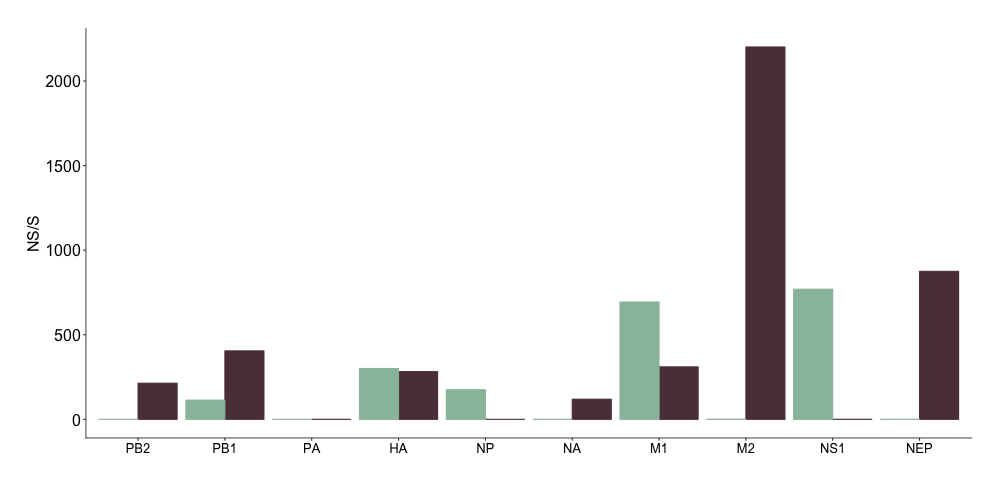

In [263]:
%%R -w 1000 -h 500 -u px -i  NoverS_df  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)

NoverS_df$gene = gsub("neuraminidase","NA", NoverS_df$gene)
NoverS_df$genef = factor(NoverS_df$gene, levels=c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP'))

p2 <- ggplot(data=NoverS_df, aes(x=genef, y=mean, color=species, fill=species)) + 
    geom_col(position="dodge")+   
    #geom_errorbar(data=NoverS_df, aes(x=genef, ymin=mean - std, ymax=mean+std), position="dodge")+
    labs(x="gene",y="NS/S")+
    scale_color_manual(values=c("#99bfaa","#5c3d46"),breaks = c("human synonymous","human nonsynonymous","duck synonymous","duck nonsynonymous"))+
    scale_fill_manual(values=c("#99bfaa","#5c3d46"),breaks = c("human synonymous","human nonsynonymous","duck synonymous","duck nonsynonymous"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #scale_y_log10(limits=c(-0.001,10000), breaks=c(0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000))+
    theme(strip.text = element_text(size=16))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-15))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=13))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    #theme(legend.key=element_rect(fill=NA,size = 2))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2
#ggsave("Fig-5-NS_S_SNPs_per_site-2019-02-11.pdf", p, width = 13, height = 6, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-01-08")

In [204]:
humanList = []

geneList = list(set(human['gene']))

for gene in geneList:
    genedf = human[human['gene'] == gene]['N_over_S']
    genedf = genedf.reset_index(drop=True)
    
    humanList.append(genedf)
    
    human_compare = pd.concat(humanList, axis=1)

human_compare.columns = geneList
human_compare

,PA,NEP,HA,NP,neuraminidase,M2,PB1,PB2,NS1,M1
0,2.201002,3496.381688,3.340370,0.602750,0.283898,4389.694987,0.284555,0.147074,0.000154,750.213720
1,0.551321,3496.872957,0.557052,0.000173,0.283452,0.000064,0.000126,0.295446,0.098943,1728.110599
2,0.137884,1.000000,0.000370,0.301236,951.636286,4405.286344,0.142796,1706.998695,0.000154,0.613586
3,0.000233,1.000000,2251.958144,0.303851,0.000149,8810.936900,0.142796,1.499936,0.000154,0.000059
4,0.415577,1.000000,0.556224,0.228054,0.282711,1.000000,2830.712202,0.449637,1.000000,0.153246
5,0.092357,1.000000,0.185411,0.000348,0.283055,1.000000,1.000000,0.000525,1.000000,1.000000
6,0.552607,1.000000,0.000185,0.304044,0.000297,1.000000,1.000000,0.300400,1.000000,1.000000
7,0.000466,1.000000,0.558318,1.000000,1.000000,1.000000,NaN,0.000263,1.000000,1.000000


In [205]:
duckList = []

geneList = list(set(duck['gene']))

for gene in geneList:
    genedf = duck[duck['gene'] == gene]['N_over_S']
    genedf = genedf.reset_index(drop=True)
    
    duckList.append(genedf)
    
    duck_compare = pd.concat(duckList, axis=1)

duck_compare.columns = geneList
duck_compare

,PA,neuraminidase,HA,NP,M2,PB1,PB2,NEP,NS1,M1
0,0.138628,0.283468,750.562922,0.301394,1.0,0.000505,0.000131,0.269297,3842.459174,1732.764071
1,0.000464,0.000297,751.691305,872.248397,1.0,566.211492,0.000525,1.000000,1.000000,1732.601790
2,0.000466,1.000000,0.000370,0.182399,1.0,0.000252,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,0.280050,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


### Run t-tests

In [206]:
h_PB1 = human_compare[["PB1"]].dropna()
d_PB1 = duck_compare[['PB1']].dropna()
stats.ttest_ind(h_PB1, d_PB1, axis=0, equal_var=False)

Ttest_indResult(statistic=array([0.69335823]), pvalue=array([0.51070142]))

In [207]:
h_PB2 = human_compare[["PB2"]].dropna()
d_PB2 = duck_compare[['PB2']].dropna()
stats.ttest_ind(h_PB2, d_PB2, axis=0, equal_var=False)

Ttest_indResult(statistic=array([0.99898941]), pvalue=array([0.35107294]))

In [208]:
h_PA = human_compare[["PA"]].dropna()
d_PA = duck_compare[['PA']].dropna()
stats.ttest_ind(h_PA, d_PA, axis=0, equal_var=False)

Ttest_indResult(statistic=array([0.18956069]), pvalue=array([0.85322851]))

In [209]:
h_HA = human_compare[["HA"]].dropna()
d_HA = duck_compare[['HA']].dropna()
stats.ttest_ind(h_HA, d_HA, axis=0, equal_var=False)

Ttest_indResult(statistic=array([-0.05521979]), pvalue=array([0.95697105]))

In [210]:
h_NP = human_compare[["NP"]].dropna()
d_NP = duck_compare[['NP']].dropna()
stats.ttest_ind(h_NP, d_NP, axis=0, equal_var=False)

Ttest_indResult(statistic=array([-1.00159626]), pvalue=array([0.37321615]))

In [211]:
h_NA = human_compare[["neuraminidase"]].dropna()
d_NA = duck_compare[["neuraminidase"]].dropna()
stats.ttest_ind(h_NA, d_NA, axis=0, equal_var=False)

Ttest_indResult(statistic=array([0.99703824]), pvalue=array([0.35195523]))

In [212]:
h_M1 = human_compare[["M1"]].dropna()
d_M1 = duck_compare[['M1']].dropna()
stats.ttest_ind(h_M1, d_M1, axis=0, equal_var=False)

Ttest_indResult(statistic=array([-0.80025168]), pvalue=array([0.45294882]))

In [215]:
h_M2 = human_compare[["M2"]].dropna()
d_M2 = duck_compare[['M2']].dropna()
stats.ttest_ind(h_M2, d_M2, axis=0, equal_var=False)

Ttest_indResult(statistic=array([1.86976628]), pvalue=array([0.10371342]))

In [213]:
h_NS1 = human_compare[["NS1"]].dropna()
d_NS1 = duck_compare[['NS1']].dropna()
stats.ttest_ind(h_NS1, d_NS1, axis=0, equal_var=False)

Ttest_indResult(statistic=array([-1.00063459]), pvalue=array([0.3736286]))

In [214]:
h_NEP = human_compare[["NEP"]].dropna()
d_NEP = duck_compare[['NEP']].dropna()
stats.ttest_ind(h_NEP, d_NEP, axis=0, equal_var=False)

Ttest_indResult(statistic=array([1.52778062]), pvalue=array([0.17040845]))

### Single gene results: 

These tests tested the hypothesis that the ratio of NS/S is different in humans and ducks in each gene. No gene showed any evidence of a significant difference in the ratio of NS and S diversity between humans and ducks. 